 # Compas Analysis



 What follows are the calculations performed for ProPublica's analysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.



 ## Loading the Data



 We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
# from lifelines.statistics import logrank_test

In [2]:
raw_data = pd.read_csv("data/compas-scores-two-years.csv")
print(len(raw_data))

7214


 However not all of the rows are usable for the first round of analysis.



 There are a number of reasons to remove rows because of missing data:

 * If the charge date of a defendant's Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.

 * We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.

 * In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time and are removed (only two of them).

 * We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years or had at least two years outside of a correctional facility.

In [3]:
df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]

df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30)]
df = df[df['is_recid'] != -1]
df = df[df['c_charge_degree'] != "O"]
df = df[df['score_text'] != 'N/A']

print(len(df))

6172


 Higher COMPAS scores are slightly correlated with a longer length of stay.

In [4]:
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])).dt.days
print(df['length_of_stay'].corr(df['decile_score']))

0.2074780847803178


 After filtering we have the following demographic breakdown:

In [5]:
print(df['age_cat'].describe())

count        6172
unique          3
top       25 - 45
freq         3532
Name: age_cat, dtype: object


In [6]:
print(df['race'].describe())

count                 6172
unique                   6
top       African-American
freq                  3175
Name: race, dtype: object


In [7]:
print(f"Black defendants: {3175 / 6172 * 100:.2f}%")
print(f"White defendants: {2103 / 6172 * 100:.2f}%")
print(f"Hispanic defendants: {509  / 6172 * 100:.2f}%")
print(f"Asian defendants: {31   / 6172 * 100:.2f}%")
print(f"Native American defendants: {11   / 6172 * 100:.2f}%")

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [8]:
print(df['score_text'].describe())

count     6172
unique       3
top        Low
freq      3421
Name: score_text, dtype: object


In [9]:
print(pd.crosstab(df['sex'], df['race']))

race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               549      2        482        82                2     58
Male                2626     29       1621       427                9    285


In [10]:
print(df['sex'].describe())

count     6172
unique       2
top       Male
freq      4997
Name: sex, dtype: object


In [11]:
print(f"Men: {4997 / 6172 * 100:.2f}%")
print(f"Women: {1175 / 6172 * 100:.2f}%")

Men: 80.96%
Women: 19.04%


In [12]:
print(len(df[df['two_year_recid'] == 1]))

2809


In [13]:
print(len(df[df['two_year_recid'] == 1]) / len(df) * 100)

45.51198963058976


 Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium, and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

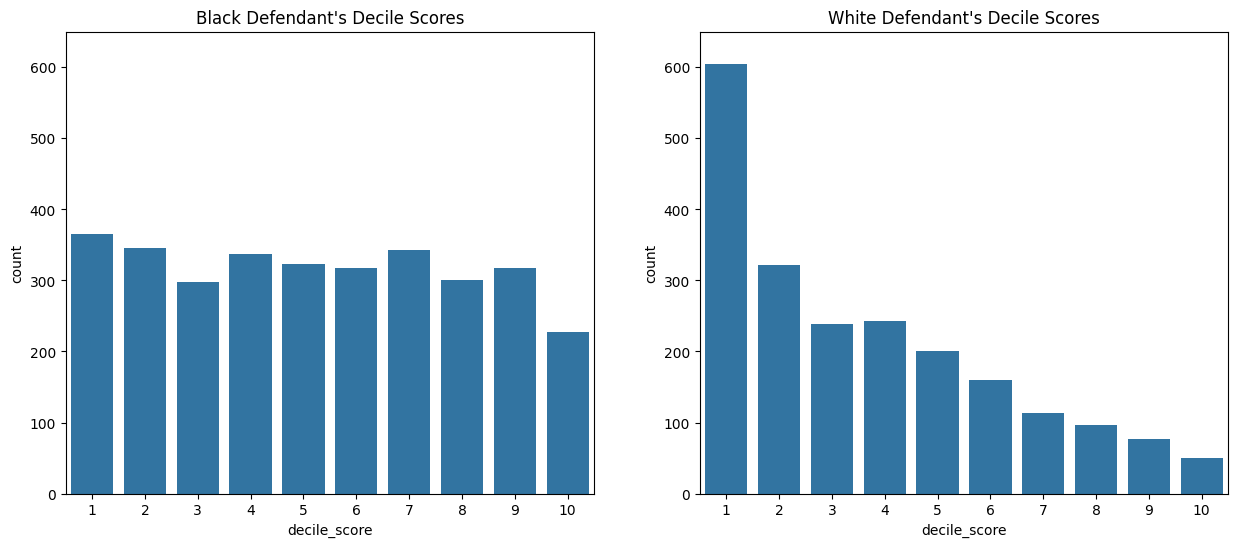

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(x='decile_score', data=df[df['race'] == 'African-American'], ax=axes[0])
axes[0].set_title("Black Defendant's Decile Scores")
axes[0].set_ylim(0, 650)

sns.countplot(x='decile_score', data=df[df['race'] == 'Caucasian'], ax=axes[1])
axes[1].set_title("White Defendant's Decile Scores")
axes[1].set_ylim(0, 650)

plt.show()

In [15]:
print(pd.crosstab(df['decile_score'], df['race']))

race          African-American  Asian  Caucasian  Hispanic  Native American  \
decile_score                                                                  
1                          365     15        605       159                0   
2                          346      4        321        89                2   
3                          298      5        238        73                1   
4                          337      0        243        47                0   
5                          323      1        200        39                0   
6                          318      2        160        27                2   
7                          343      1        113        28                2   
8                          301      2         96        14                0   
9                          317      0         77        17                2   
10                         227      1         50        16                2   

race          Other  
decile_score         
1      

 ## Racial Bias in Compas



 After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [16]:
# Ensure score_factor is a numeric type (0 or 1)
df['score_factor'] = (df['score_text'] != "Low").astype(int)

# Convert categorical variables to category type
df['crime_factor'] = df['c_charge_degree'].astype('category')
df['age_factor'] = df['age_cat'].astype('category')
df['race_factor'] = df['race'].astype('category')
df['gender_factor'] = df['sex'].astype('category')

# Fit the logistic regression model
model = logit("score_factor ~ gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid", data=df).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           score_factor   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.2729
Time:                        11:18:02   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.8271      0.091     -9.132     

 Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [17]:
control = np.exp(-1.52554) / (1 + np.exp(-1.52554))
print(np.exp(0.47721) / (1 - control + (control * np.exp(0.47721))))

1.4528408658138932


 Women are 19.4% more likely than men to get a higher score.

In [18]:
print(np.exp(0.22127) / (1 - control + (control * np.exp(0.22127))))

1.1947978508506671


 Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle-aged defendants.

In [19]:
print(np.exp(1.30839) / (1 - control + (control * np.exp(1.30839))))

2.4961202077189455


 ### Risk of Violent Recidivism



 Compas also offers a score that aims to measure a person's risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [20]:
raw_data_violent = pd.read_csv("data/compas-scores-two-years-violent.csv")
print(len(raw_data_violent))

4743


In [21]:
df_violent = raw_data_violent[['age', 'c_charge_degree', 'race', 'age_cat', 'v_score_text', 'sex', 'priors_count',
                               'days_b_screening_arrest', 'v_decile_score', 'is_recid', 'two_year_recid']]

df_violent = df_violent[(df_violent['days_b_screening_arrest'] <= 30) & (df_violent['days_b_screening_arrest'] >= -30)]
df_violent = df_violent[df_violent['is_recid'] != -1]
df_violent = df_violent[df_violent['c_charge_degree'] != "O"]
df_violent = df_violent[df_violent['v_score_text'] != 'N/A']

print(len(df_violent))

4020


In [22]:
print(df_violent['age_cat'].describe())

count        4020
unique          3
top       25 - 45
freq         2300
Name: age_cat, dtype: object


In [23]:
print(df_violent['race'].describe())

count                 4020
unique                   6
top       African-American
freq                  1918
Name: race, dtype: object


In [24]:
print(df_violent['v_score_text'].describe())

count     4020
unique       3
top        Low
freq      2913
Name: v_score_text, dtype: object


In [25]:
print(len(df_violent[df_violent['two_year_recid'] == 1]) / len(df_violent) * 100)

16.218905472636816


In [26]:
print(len(df_violent[df_violent['two_year_recid'] == 1]))

652


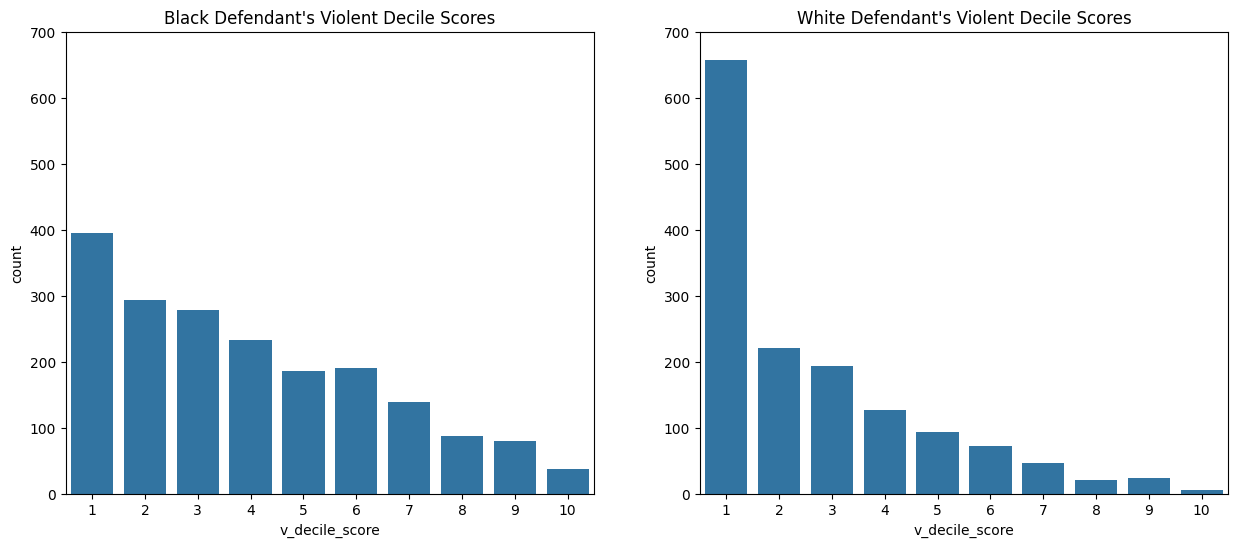

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(x='v_decile_score', data=df_violent[df_violent['race'] == 'African-American'], ax=axes[0])
axes[0].set_title("Black Defendant's Violent Decile Scores")
axes[0].set_ylim(0, 700)

sns.countplot(x='v_decile_score', data=df_violent[df_violent['race'] == 'Caucasian'], ax=axes[1])
axes[1].set_title("White Defendant's Violent Decile Scores")
axes[1].set_ylim(0, 700)

plt.show()

In [28]:
df_violent['crime_factor'] = df_violent['c_charge_degree'].astype('category')
df_violent['age_factor'] = df_violent['age_cat'].astype('category')
df_violent['race_factor'] = df_violent['race'].astype('category')
df_violent['gender_factor'] = df_violent['sex'].astype('category')
df_violent['score_factor'] = (df_violent['v_score_text'] != "Low").astype('int')

model_violent = logit("score_factor ~ gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid", data=df_violent).fit()
print(model_violent.summary())

Optimization terminated successfully.
         Current function value: 0.372983
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           score_factor   No. Observations:                 4020
Model:                          Logit   Df Residuals:                     4008
Method:                           MLE   Df Model:                           11
Date:                Thu, 11 Jul 2024   Pseudo R-squ.:                  0.3662
Time:                        11:18:02   Log-Likelihood:                -1499.4
converged:                       True   LL-Null:                       -2365.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -2.3127      0.141    -16.360     

 The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

In [29]:
control_violent = np.exp(-2.24274) / (1 + np.exp(-2.24274))
print(np.exp(0.65893) / (1 - control_violent + (control_violent * np.exp(0.65893))))

1.7739209589164604


 Defendants under 25 are 7.4 times as likely to get a higher score as middle-aged defendants.

In [30]:
print(np.exp(3.14591) / (1 - control_violent + (control_violent * np.exp(3.14591))))

7.414239863565466


 ## Predictive Accuracy of COMPAS



 In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium, or High risk, we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their [validation study](http://cjb.sagepub.com/content/36/1/21.abstract).



 We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [31]:
data_cox = pd.read_csv("data/cox-parsed.csv")
data_cox = data_cox[(data_cox['score_text'] != "N/A") & (data_cox['end'] > data_cox['start'])]

data_cox['race_factor'] = data_cox['race'].astype('category')
data_cox['score_factor'] = data_cox['score_text'].astype('category')

grp = data_cox.drop_duplicates(subset=['id'])
print(len(grp))

10325


In [32]:
print(grp['score_factor'].describe())

count     10314
unique        3
top         Low
freq       5751
Name: score_factor, dtype: object


In [33]:
print(grp['race_factor'].describe())

count                10325
unique                   6
top       African-American
freq                  5150
Name: race_factor, dtype: object


In [37]:
data_cox.shape

(13356, 54)

In [46]:
cph = CoxPHFitter()
cph.fit(
    data_cox,
    duration_col="end",
    # event_col="event",
    # formula="score_factor + gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid",
)

ValueError: Cannot cast object dtype to float64

In [47]:
cph = CoxPHFitter()
cph.fit(
    data_cox,
    # duration_col="end",
    event_col="event",
    # start_col="start",
    formula="score_factor",
)
# cph.print_summary()

KeyError: None

 People placed in the High category are 3.5 times as likely to recidivate, and the COMPAS system's concordance is 63.6%. This is lower than the accuracy quoted in the Northpoint study of 68%.

In [ ]:
cph_decile = CoxPHFitter()
cph_decile.fit(data_cox, duration_col='end', event_col='event', start_col='start', formula="decile_score")
cph_decile.print_summary()

 COMPAS's decile scores are a bit more accurate at 66%.



 We can test if the algorithm is behaving differently across races by including a race interaction term in the Cox model.

In [ ]:
cph_race_interaction = CoxPHFitter()
cph_race_interaction.fit(data_cox, duration_col='end', event_col='event', start_col='start', formula="race_factor * score_factor")
cph_race_interaction.print_summary()

 The interaction term shows a similar disparity as the logistic regression above.



 High-risk white defendants are 3.61 more likely than low-risk white defendants, while high-risk black defendants are 2.99 more likely than low.

In [69]:
print(f"Black High Hazard: {np.exp(-0.18976 + 1.28350):.2f}")
print(f"White High Hazard: {np.exp(1.28350):.2f}")
print(f"Black Medium Hazard: {np.exp(0.84286-0.17261):.2f}")
print(f"White Medium Hazard: {np.exp(0.84286):.2f}")

Black High Hazard: 2.99
White High Hazard: 3.61
Black Medium Hazard: 1.95
White Medium Hazard: 2.32


In [70]:
kmf = KaplanMeierFitter()
kmf.fit(data_cox['end'], event_observed=data_cox['event'], start_time=data_cox['start'])

kmf.plot_survival_function()
plt.title('Overall')
plt.ylim(0, 1)
plt.show()

TypeError: KaplanMeierFitter.fit() got an unexpected keyword argument 'start_time'

 Black defendants do recidivate at higher rates according to race-specific Kaplan Meier plots.

In [ ]:
white = data_cox[data_cox['race'] == "Caucasian"]
black = data_cox[data_cox['race'] == "African-American"]

kmf_white = KaplanMeierFitter()
kmf_black = KaplanMeierFitter()

kmf_white.fit(white['end'], event_observed=white['event'], start_time=white['start'])
kmf_black.fit(black['end'], event_observed=black['event'], start_time=black['start'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

kmf_white.plot_survival_function(ax=axes[0])
axes[0].set_title("White defendants")
axes[0].set_ylim(0, 1)

kmf_black.plot_survival_function(ax=axes[1])
axes[1].set_title("Black defendants")
axes[1].set_ylim(0, 1)

plt.show()

In [ ]:
print(kmf.survival_function_at_times([730]))

In [ ]:
print(kmf_black.survival_function_at_times([730]))

In [ ]:
print(kmf_white.survival_function_at_times([730]))

 Race-specific models have similar concordance values.

In [ ]:
cph_white = CoxPHFitter()
cph_white.fit(white, duration_col='end', event_col='event', start_col='start', formula="score_factor")
cph_white.print_summary()

In [ ]:
cph_black = CoxPHFitter()
cph_black.fit(black, duration_col='end', event_col='event', start_col='start', formula="score_factor")
cph_black.print_summary()

 Compas's violent recidivism score has a slightly higher overall concordance score of 65.1%.

In [ ]:
violent_data = pd.read_csv("./cox-violent-parsed.csv")
violent_data = violent_data[(violent_data['score_text'] != "N/A") & (violent_data['end'] > violent_data['start'])]

violent_data['race_factor'] = violent_data['race'].astype('category')
violent_data['score_factor'] = violent_data['score_text'].astype('category')

cph_violent = CoxPHFitter()
cph_violent.fit(violent_data, duration_col='end', event_col='event', start_col='start', formula="score_factor")
vgrp = violent_data.drop_duplicates(subset=['id'])
print(len(vgrp))
cph_violent.print_summary()

 In this case, there isn't a significant coefficient on African Americans with High Scores.

In [ ]:
cph_violent_race_interaction = CoxPHFitter()
cph_violent_race_interaction.fit(violent_data, duration_col='end', event_col='event', start_col='start', formula="race_factor * score_factor")
cph_violent_race_interaction.print_summary()

In [ ]:
cph_violent_black = CoxPHFitter()
cph_violent_black.fit(violent_data[violent_data['race'] == "African-American"], duration_col='end', event_col='event', start_col='start', formula="score_factor")
cph_violent_black.print_summary()

In [ ]:
cph_violent_white = CoxPHFitter()
cph_violent_white.fit(violent_data[violent_data['race'] == "Caucasian"], duration_col='end', event_col='event', start_col='start', formula="score_factor")
cph_violent_white.print_summary()

In [ ]:
white_violent = violent_data[violent_data['race'] == "Caucasian"]
black_violent = violent_data[violent_data['race'] == "African-American"]

kmf_white_violent = KaplanMeierFitter()
kmf_black_violent = KaplanMeierFitter()

kmf_white_violent.fit(white_violent['end'], event_observed=white_violent['event'], start_time=white_violent['start'])
kmf_black_violent.fit(black_violent['end'], event_observed=black_violent['event'], start_time=black_violent['start'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

kmf_white_violent.plot_survival_function(ax=axes[0])
axes[0].set_title("White defendants")
axes[0].set_ylim(0, 1)

kmf_black_violent.plot_survival_function(ax=axes[1])
axes[1].set_title("Black defendants")
axes[1].set_ylim(0, 1)

plt.show()

 ## Directions of the Racial Bias



 The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

In [ ]:

from
